# Problem 4.2
The task is to determine the optimal horizontal and vertical euclidean distance
thresholds between bounding boxes containing words on a document page. The
objective of this task is to establish connections between boxes within a paragraph while ensuring that boxes across paragraphs and columns remain unconnected.

In [832]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import ast

### Running the script
read the csv after finding horizontal threshold, vertical thresholds. make it such that it follows the given format:

1. final csv is the csv that has columns Id, Top-Left, Bottom-Right, Top, Left, Bottom, Right, Top_box, Bottom_box, Left_box, Right_box

2. Id - refers to box ID -> int

3. Top-Left,Bottom-Right - refers to the xy coordinates of topleft and bottomright coordinate of a bounding box

4. Top/Left/Bottom/Right - refers to the coordinates of edge centers

5. Top_box/Bottom_box/Left_box/Right_box - refers to the nearest box from current box such that the words across paragraphs or columns should not get connected -> List:[dist, nearest box ID]


In [833]:
## Obtain the new dataframe
# Read the csv file
df = pd.read_csv('4_2-Datasets/CSV/TLBR_29.csv')

# Initialize lists to store the new columns
top = []
left = []
bottom = []
right = []

# Iterate through each row
for idx, row in df.iterrows():
    # Extract coordinates from string to list
    top_left = ast.literal_eval(row['Top-Left'])
    bottom_right = ast.literal_eval(row['Bottom-Right'])

    # Calculate the center coordinates
    top_center = (top_left[0], (top_left[1] + bottom_right[1]) // 2)
    left_center = ((top_left[0] + bottom_right[0]) // 2, top_left[1])
    bottom_center = (bottom_right[0], (top_left[1] + bottom_right[1]) // 2)
    right_center = ((top_left[0] + bottom_right[0]) // 2, bottom_right[1])

    # Append the calculated values to the respective lists
    top.append(top_center)
    left.append(left_center)
    bottom.append(bottom_center)
    right.append(right_center)
    

# Create a new DataFrame with the desired format
new_df = pd.DataFrame({
    'Id': df['Id'],
    'Top-Left': df['Top-Left'],
    'Bottom-Right': df['Bottom-Right'],
    'Top': top,
    'Left': left,
    'Bottom': bottom,
    'Right': right
})

### Perform Hierarchical Clustering on the above dataframe

In [834]:
new_df.info()
new_df.head()
print(type(new_df['Top'][0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            432 non-null    int64 
 1   Top-Left      432 non-null    object
 2   Bottom-Right  432 non-null    object
 3   Top           432 non-null    object
 4   Left          432 non-null    object
 5   Bottom        432 non-null    object
 6   Right         432 non-null    object
dtypes: int64(1), object(6)
memory usage: 23.8+ KB
<class 'tuple'>


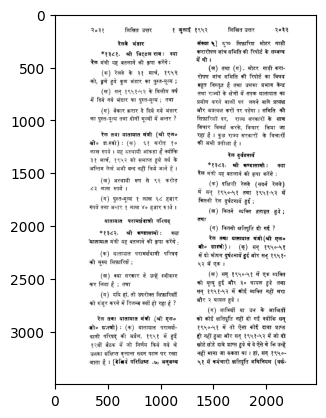

In [835]:
img = cv2.imread('/home/anika/Desktop/smai/A2/4_2-Datasets/images/29.jpg')
# plot the image to decide the number of clusters/paragraphs
plt.imshow(img)
plt.show()

In [836]:
# Calculate the center coordinates and store them in a numpy array
coordinates = np.array(new_df[['Top', 'Left', 'Bottom', 'Right']].values.tolist())
# print(coordinates.shape) -> (432, 4, 2)
# calculate the average for each datapoint
coordinates = np.mean(coordinates, axis=1)

# add a new column with the center coordinates
new_df['Center'] = coordinates.tolist()

# Separate X and Y coordinates
x_coordinates = coordinates[:, 0]
y_coordinates = coordinates[:, 1]

# Perform hierarchical clustering on X coordinates
x_linkage_matrix = linkage(x_coordinates.reshape(-1, 1), method='ward')
x_clusters = fcluster(x_linkage_matrix, t=4, criterion='maxclust')  # Adjust 't' as needed

# Perform hierarchical clustering on Y coordinates
y_linkage_matrix = linkage(y_coordinates.reshape(-1, 1), method='ward')
y_clusters = fcluster(y_linkage_matrix, t=2, criterion='maxclust')  # Adjust 't' as needed

# Combine X and Y clusters into final clusters using tuples
final_clusters = [(x, y) for x, y in zip(x_clusters, y_clusters)]

# Print the final clusters
# for i, cluster in enumerate(final_clusters):
#     print(f"{coordinates[i]} -> Cluster {cluster}")

# assign each cluster a single number
cluster_dict = {}
cluster_num = 1
for cluster in final_clusters:
    if cluster not in cluster_dict:
        cluster_dict[cluster] = cluster_num
        cluster_num += 1

# add a new column to the dataframe with a single cluster number using the dictionary
new_df['Cluster'] = [cluster_dict[cluster] for cluster in final_clusters]

new_df.head()

,Id,Top-Left,Bottom-Right,Top,Left,Bottom,Right,Center,Cluster
0,0,"[338, 133]","[469, 185]","(338, 159)","(403, 133)","(469, 159)","(403, 185)","[403.25, 159.0]",1
1,1,"[662, 126]","[795, 178]","(662, 152)","(728, 126)","(795, 152)","(728, 178)","[728.25, 152.0]",1
2,2,"[822, 133]","[923, 185]","(822, 159)","(872, 133)","(923, 159)","(872, 185)","[872.25, 159.0]",2
3,3,"[592, 250]","[694, 314]","(592, 282)","(643, 250)","(694, 282)","(643, 314)","[643.0, 282.0]",1
4,4,"[735, 253]","[846, 308]","(735, 280)","(790, 253)","(846, 280)","(790, 308)","[790.25, 280.25]",1


In [837]:
# Calculate horizontal and vertical thresholds based on paragraph assignments
def calculate_thresholds(df):
    horizontal_thresholds = {}
    vertical_thresholds = {}

    # Iterate over unique paragraph labels
    for paragraph_label in new_df['Cluster'].unique():
        paragraph_df = new_df[new_df['Cluster'] == paragraph_label]
        
        # Calculate pairwise horizontal and vertical distances within the paragraph
        horizontal_distances = []
        vertical_distances = []

        for i, row1 in paragraph_df.iterrows():
            for j, row2 in paragraph_df.iterrows():
                if i != j:
                    horizontal_dist = np.abs(row1['Center'][0] - row2['Center'][0])
                    vertical_dist = np.abs(row1['Center'][1] - row2['Center'][1])
                    horizontal_distances.append(horizontal_dist)
                    vertical_distances.append(vertical_dist)

        # Calculate thresholds (e.g., using the median)
        horizontal_threshold = np.mean(horizontal_distances)
        vertical_threshold = np.mean(vertical_distances)

        # Store thresholds for the paragraph
        horizontal_thresholds[paragraph_label] = horizontal_threshold/8
        vertical_thresholds[paragraph_label] = vertical_threshold/2

    return horizontal_thresholds, vertical_thresholds

# Call the function to calculate thresholds
horizontal_thresholds, vertical_thresholds = calculate_thresholds(new_df)

# Print or use the calculated thresholds as needed
print("Horizontal Thresholds:", horizontal_thresholds)
print("Vertical Thresholds:", vertical_thresholds)

Horizontal Thresholds: {1: 19.353445324726135, 2: 15.734494535519126, 3: 21.51220930232558, 4: 14.0890731292517, 5: 18.480868902439024, 6: 15.744489247311828, 7: 21.73692042606516, 8: 13.884558823529412}
Vertical Thresholds: {1: 323.31479851330204, 2: 326.1296448087432, 3: 339.5735978112175, 4: 342.20089285714283, 5: 180.14207317073172, 6: 173.5021505376344, 7: 183.57926065162908, 8: 176.26638655462185}


In [838]:
# assign the maximum value of the horizontal and vertical thresholds as the threshold
vertical_thresholds = vertical_thresholds.values()
horizontal_thresholds = horizontal_thresholds.values()
# find average of the thresholds
vertical_threshold = np.mean(list(vertical_thresholds))
horizontal_threshold = np.mean(list(horizontal_thresholds))
print("Final Vertical Threshold:", vertical_threshold)
print("Final Horizontal Threshold:", horizontal_threshold)

Final Vertical Threshold: 255.58860061312785
Final Horizontal Threshold: 17.567007461395995


In [839]:
''' Calculate Top box, Bottom box, Right box, Left Box - A list containing the dis-
tance and id of the nearest neighbour in the Top, Bottom, Right and
Left directions respectively using the threshold values.

Remove the connection if the distance is greater than the threshold.To remove the connection
make sure that the list is [-1, 0]'''

' Calculate Top box, Bottom box, Right box, Left Box - A list containing the dis-\ntance and id of the nearest neighbour in the Top, Bottom, Right and\nLeft directions respectively using the threshold values.\n\nRemove the connection if the distance is greater than the threshold.To remove the connection\nmake sure that the list is [-1, 0]'

In [840]:
# Get the nearest bounding boxes in the top, bottom, right, and left directions in the same cluster
def get_nearest_bounding_boxes(df, horizontal_threshold, vertical_threshold):
    top_box = []
    bottom_box = []
    right_box = []
    left_box = []

    # Iterate over each bounding box
    for i, row1 in df.iterrows():
        top_box.append([-1, 0])
        bottom_box.append([-1, 0])
        right_box.append([-1, 0])
        left_box.append([-1, 0])

        for j, row2 in df.iterrows():  
        # check if the bounding boxes are in the same cluster
            if i != j and row1['Cluster'] == row2['Cluster']:
                # Calculate the horizontal and vertical distances
                horizontal_dist = np.abs(row1['Center'][0] - row2['Center'][0])
                vertical_dist = np.abs(row1['Center'][1] - row2['Center'][1])

                # Check if the bounding boxes are in the top, bottom, right, or left directions
                if horizontal_dist <= horizontal_threshold:
                    if row1['Center'][1] > row2['Center'][1]:
                        if top_box[i][0] == -1:
                            top_box[i] = [j, vertical_dist]
                        elif vertical_dist < top_box[i][1]:
                            top_box[i] = [j, vertical_dist]
                    elif row1['Center'][1] < row2['Center'][1]:
                        if bottom_box[i][0] == -1:
                            bottom_box[i] = [j, vertical_dist]
                        elif vertical_dist < bottom_box[i][1]:
                            bottom_box[i] = [j, vertical_dist]
                elif vertical_dist <= vertical_threshold:
                    if row1['Center'][0] > row2['Center'][0]:
                        if left_box[i][0] == -1:
                            left_box[i] = [j, horizontal_dist]
                        elif horizontal_dist < left_box[i][1]:
                            left_box[i] = [j, horizontal_dist]
                    elif row1['Center'][0] < row2['Center'][0]:
                        if right_box[i][0] == -1:
                            right_box[i] = [j, horizontal_dist]

    return top_box, bottom_box, right_box, left_box

In [841]:
# get new_df with the nearest bounding boxes
top_box, bottom_box, right_box, left_box = get_nearest_bounding_boxes(new_df, horizontal_threshold, vertical_threshold)
new_df['Top Box'] = top_box
new_df['Bottom Box'] = bottom_box
new_df['Right Box'] = right_box
new_df['Left Box'] = left_box
new_df.head()

,Id,Top-Left,Bottom-Right,Top,Left,Bottom,Right,Center,Cluster,Top Box,Bottom Box,Right Box,Left Box
0,0,"[338, 133]","[469, 185]","(338, 159)","(403, 133)","(469, 159)","(403, 185)","[403.25, 159.0]",1,"[-1, 0]","[166, 1302.25]","[1, 325.0]","[-1, 0]"
1,1,"[662, 126]","[795, 178]","(662, 152)","(728, 126)","(795, 152)","(728, 178)","[728.25, 152.0]",1,"[-1, 0]","[100, 405.0]","[4, 62.0]","[87, 26.25]"
2,2,"[822, 133]","[923, 185]","(822, 159)","(872, 133)","(923, 159)","(872, 185)","[872.25, 159.0]",2,"[-1, 0]","[109, 480.25]","[5, 251.75]","[88, 31.25]"
3,3,"[592, 250]","[694, 314]","(592, 282)","(643, 250)","(694, 282)","(643, 314)","[643.0, 282.0]",1,"[-1, 0]","[107, 369.0]","[1, 85.25]","[93, 74.0]"
4,4,"[735, 253]","[846, 308]","(735, 280)","(790, 253)","(846, 280)","(790, 308)","[790.25, 280.25]",1,"[-1, 0]","[176, 1302.0]","[-1, 0]","[1, 62.0]"


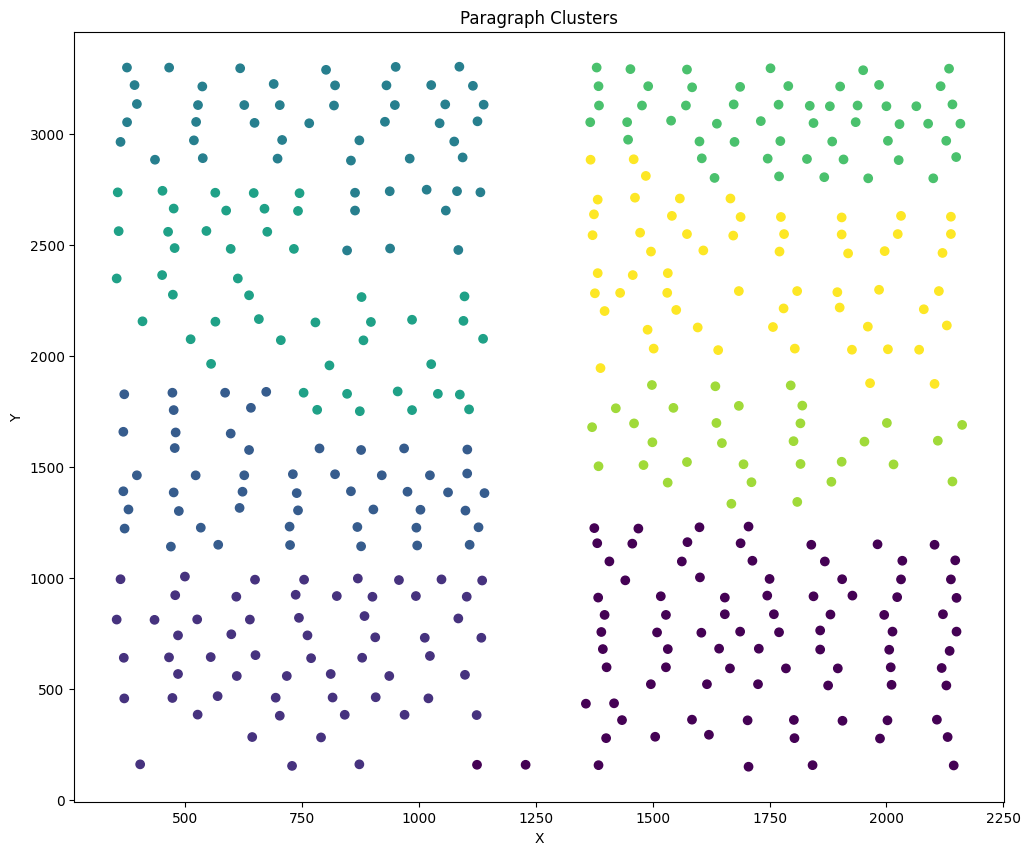

In [842]:
# plot the centers of the bounding boxes in different clusters with different colors
plt.figure(figsize=(12, 10))
plt.title('Paragraph Clusters')
plt.xlabel('X')
plt.ylabel('Y')
plt.scatter(coordinates[:, 0], coordinates[:, 1], c=cluster_assignments)
plt.show()

In [843]:
# new_df.head(20)

In [844]:
# obtain the final dataframe by removing the unwanted columns
final_df = new_df.drop(columns=['Center', 'Cluster'])
final_df.head()

,Id,Top-Left,Bottom-Right,Top,Left,Bottom,Right,Top Box,Bottom Box,Right Box,Left Box
0,0,"[338, 133]","[469, 185]","(338, 159)","(403, 133)","(469, 159)","(403, 185)","[-1, 0]","[166, 1302.25]","[1, 325.0]","[-1, 0]"
1,1,"[662, 126]","[795, 178]","(662, 152)","(728, 126)","(795, 152)","(728, 178)","[-1, 0]","[100, 405.0]","[4, 62.0]","[87, 26.25]"
2,2,"[822, 133]","[923, 185]","(822, 159)","(872, 133)","(923, 159)","(872, 185)","[-1, 0]","[109, 480.25]","[5, 251.75]","[88, 31.25]"
3,3,"[592, 250]","[694, 314]","(592, 282)","(643, 250)","(694, 282)","(643, 314)","[-1, 0]","[107, 369.0]","[1, 85.25]","[93, 74.0]"
4,4,"[735, 253]","[846, 308]","(735, 280)","(790, 253)","(846, 280)","(790, 308)","[-1, 0]","[176, 1302.0]","[-1, 0]","[1, 62.0]"


In [845]:
# img = cv2.imread('/home/anika/Desktop/smai/A2/4_2-Datasets/images/29.jpg')

### General information regarding the following fuctions used in the script:
Given below are two functions to visualize the document image and the connections established.

visualize_bboxes() can be used to visualize a document image with the bounding boxes around words. Bounding box information is given in the CSVs provided

make_connections() can be used to verify and visualize the connections established between words such that it satisfies the given criteria of grouping words in a logical paragraph. This function has to be used after getting the final csv in the specified format

In [846]:
# img_4 = img.copy()
# top_left = (int(final_df['Top-Left'][0].split(',')[0][1:]),int(final_df['Top-Left'][0].split(',')[1][:-1]))
# bottom_right = (int(final_df['Bottom-Right'][0].split(',')[0][1:]),int(final_df['Bottom-Right'][0].split(',')[1][:-1]))

# cv2.rectangle(img_4, top_left, bottom_right, (255, 0, 0), 2)
# plt.imshow(img_4)
# plt.show()
# print(top_left)

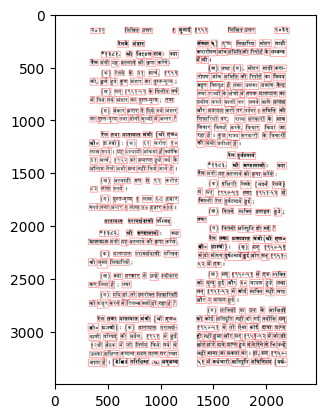

In [847]:
# plt.figure(figsize=(18, 12))
def visualize_bboxes(img):
  img_2 = img.copy()

  for i in range(432):
    top_left = (int(final_df['Top-Left'][i].split(',')[0][1:]),int(final_df['Top-Left'][i].split(',')[1][:-1]))
    bottom_right = (int(final_df['Bottom-Right'][i].split(',')[0][1:]),int(final_df['Bottom-Right'][i].split(',')[1][:-1]))
    # print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

  plt.imshow(img_2)
  # plt.show()

visualize_bboxes(img)

In [848]:
# visualize_bboxes(img)

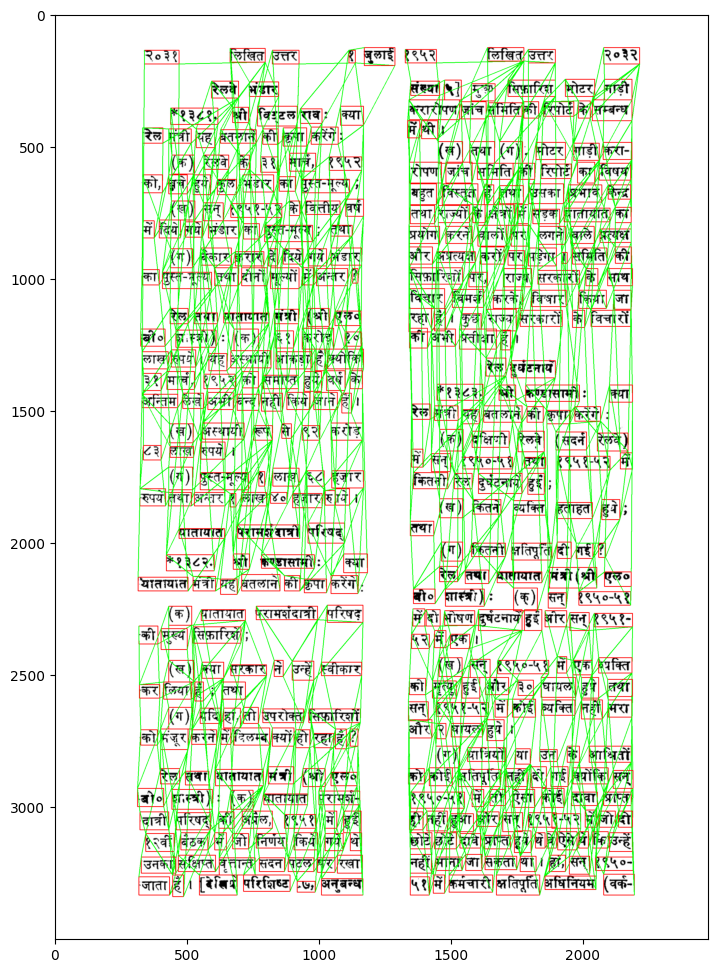

In [849]:
def make_connections(image):
    img_3 = image.copy()
    plt.figure(figsize=(18, 12))
    # visualize_bboxes(img)
    for i in range(432):
        #--------------------------
        top_left = (int(final_df['Top-Left'][i].split(',')[0][1:]),int(final_df['Top-Left'][i].split(',')[1][:-1]))
        bottom_right = (int(final_df['Bottom-Right'][i].split(',')[0][1:]),int(final_df['Bottom-Right'][i].split(',')[1][:-1]))
        # print(top_left)
        cv2.rectangle(img_3, top_left, bottom_right, (255, 0, 0), 2)
        #--------------------------
        top_left = (int(final_df['Top-Left'][i].split(',')[0][1:]),int(final_df['Top-Left'][i].split(',')[1][:-1]))
        bottom_right = (int(final_df['Bottom-Right'][i].split(',')[0][1:]),int(final_df['Bottom-Right'][i].split(',')[1][:-1]))
        top = final_df['Top Box'][i][0]
        bottom = final_df['Bottom Box'][i][0]
        right = final_df['Right Box'][i][0]
        left = final_df['Left Box'][i][0]
        if top != -1:
            top_left_2 = (int(final_df['Top-Left'][top].split(',')[0][1:]),int(final_df['Top-Left'][top].split(',')[1][:-1]))
            bottom_right_2 = (int(final_df['Bottom-Right'][top].split(',')[0][1:]),int(final_df['Bottom-Right'][top].split(',')[1][:-1]))
            cv2.line(img_3, (top_left[0], top_left[1]), (top_left_2[0], top_left_2[1]), (0, 255, 0), 2)
        if bottom != -1:
            top_left_2 = (int(final_df['Top-Left'][bottom].split(',')[0][1:]),int(final_df['Top-Left'][bottom].split(',')[1][:-1]))
            bottom_right_2 = (int(final_df['Bottom-Right'][bottom].split(',')[0][1:]),int(final_df['Bottom-Right'][bottom].split(',')[1][:-1]))
            cv2.line(img_3, (bottom_right[0], bottom_right[1]), (bottom_right_2[0], bottom_right_2[1]), (0, 255, 0), 2)
        if right != -1:
            top_left_2 = (int(final_df['Top-Left'][right].split(',')[0][1:]),int(final_df['Top-Left'][right].split(',')[1][:-1]))
            bottom_right_2 = (int(final_df['Bottom-Right'][right].split(',')[0][1:]),int(final_df['Bottom-Right'][right].split(',')[1][:-1]))
            cv2.line(img_3, (bottom_right[0], bottom_right[1]), (bottom_right_2[0], bottom_right_2[1]), (0, 255, 0), 2)
        if left != -1:
            top_left_2 = (int(final_df['Top-Left'][left].split(',')[0][1:]),int(final_df['Top-Left'][left].split(',')[1][:-1]))
            bottom_right_2 = (int(final_df['Bottom-Right'][left].split(',')[0][1:]),int(final_df['Bottom-Right'][left].split(',')[1][:-1]))
            cv2.line(img_3, (top_left[0], top_left[1]), (top_left_2[0], top_left_2[1]), (0, 255, 0), 2)
            
    plt.imshow(img_3)


make_connections(img)

In [850]:
# make_connections(img, final_df)